Adapter from:

https://github.com/bentrevett/pytorch-sentiment-analysis/blob/main/2%20-%20Recurrent%20Neural%20Networks.ipynb

In [1]:
import pandas as pd
import numpy as np

import torch
import torch.nn.functional as F
from torch import nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

import re

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords

import matplotlib.pyplot as plt

In [2]:
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_rus to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |  

True

In [4]:
!unzip /root/nltk_data/corpora/wordnet.zip -d /content/nltk_data/corpora/

Archive:  /root/nltk_data/corpora/wordnet.zip
   creating: /content/nltk_data/corpora/wordnet/
  inflating: /content/nltk_data/corpora/wordnet/lexnames  
  inflating: /content/nltk_data/corpora/wordnet/data.verb  
  inflating: /content/nltk_data/corpora/wordnet/index.adv  
  inflating: /content/nltk_data/corpora/wordnet/adv.exc  
  inflating: /content/nltk_data/corpora/wordnet/index.verb  
  inflating: /content/nltk_data/corpora/wordnet/cntlist.rev  
  inflating: /content/nltk_data/corpora/wordnet/data.adj  
  inflating: /content/nltk_data/corpora/wordnet/index.adj  
  inflating: /content/nltk_data/corpora/wordnet/LICENSE  
  inflating: /content/nltk_data/corpora/wordnet/citation.bib  
  inflating: /content/nltk_data/corpora/wordnet/noun.exc  
  inflating: /content/nltk_data/corpora/wordnet/verb.exc  
  inflating: /content/nltk_data/corpora/wordnet/README  
  inflating: /content/nltk_data/corpora/wordnet/index.sense  
  inflating: /content/nltk_data/corpora/wordnet/data.noun  
  inflat

In [5]:
# Load the dataset
training_data_path = '/content/twitter_training.csv'
validation_data_path = '/content/twitter_validation.csv'

training_data = pd.read_csv(training_data_path)
validation_data = pd.read_csv(validation_data_path)

columns = ["tweet id", "entity", "sentiment", "content"]
training_data.columns = columns
validation_data.columns = columns


In [6]:
training_data["sentiment"].unique()

array(['Positive', 'Neutral', 'Negative', 'Irrelevant'], dtype=object)

### Pre processing

In [7]:
lb = LabelEncoder()
training_data["label_sentiment"] = lb.fit_transform(training_data["sentiment"])

In [8]:
training_data.head()

,tweet id,entity,sentiment,content,label_sentiment
0,2401,Borderlands,Positive,I am coming to the borders and I will kill you...,3
1,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...,3
2,2401,Borderlands,Positive,im coming on borderlands and i will murder you...,3
3,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...,3
4,2401,Borderlands,Positive,im getting into borderlands and i can murder y...,3


In [9]:
training_data.isnull().sum()

tweet id             0
entity               0
sentiment            0
content            686
label_sentiment      0
dtype: int64

In [10]:
training_data.dropna(inplace=True)

In [11]:
training_data.isnull().sum()

tweet id           0
entity             0
sentiment          0
content            0
label_sentiment    0
dtype: int64

In [12]:
lb.classes_

array(['Irrelevant', 'Negative', 'Neutral', 'Positive'], dtype=object)

In [13]:
training_data["sentiment"].value_counts()

sentiment
Negative      22358
Positive      20654
Neutral       18108
Irrelevant    12875
Name: count, dtype: int64

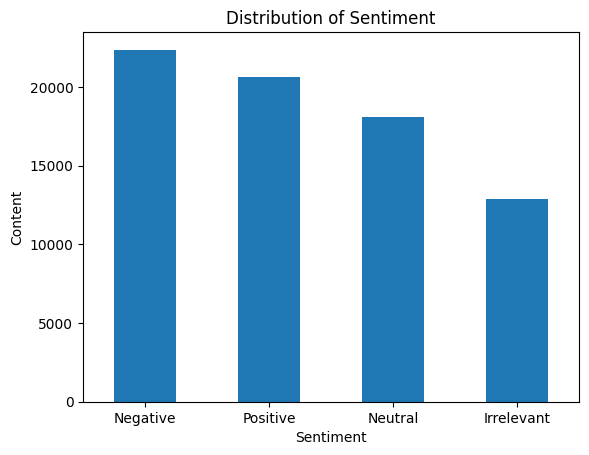

In [14]:
value_counts = training_data["sentiment"].value_counts()
ax = value_counts.plot(kind='bar')

ax.set_xticklabels(['Negative', 'Positive', 'Neutral', 'Irrelevant'], rotation=0)

plt.title('Distribution of Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Content')

plt.show()

In [15]:
nltk.download('wordnet')
nltk.download('stopwords')
wnl = WordNetLemmatizer()
stop_words = stopwords.words('english')

def preprocessing_text(text):
    text = re.sub('[^A-Za-z]+', ' ', text)
    text = text.split()
    text = " ".join([wnl.lemmatize(word) for word in text if not word in stop_words and len(word) >= 3])
    return text.lower()


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [16]:
print(preprocessing_text("im getting on borderlands and i will murder you"))

getting borderland murder


In [17]:
training_data["content"] = training_data["content"].apply(preprocessing_text)

In [18]:
training_data.head()

,tweet id,entity,sentiment,content,label_sentiment
0,2401,Borderlands,Positive,coming border kill,3
1,2401,Borderlands,Positive,getting borderland kill,3
2,2401,Borderlands,Positive,coming borderland murder,3
3,2401,Borderlands,Positive,getting borderland murder,3
4,2401,Borderlands,Positive,getting borderland murder,3


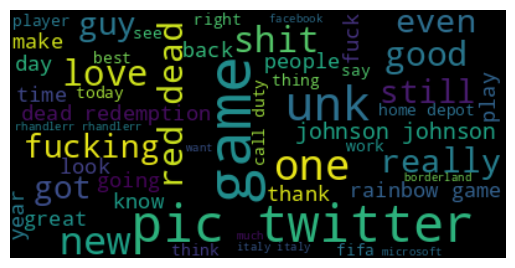

In [19]:
from PIL import Image
from wordcloud import WordCloud

text = " ".join(training_data["content"])

wordcloud = WordCloud(max_font_size=50, max_words=50, background_color="blacK").generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [20]:
from random import randint

x = randint(0, training_data.shape[0])

training_data.iloc[x:x+5, :]

,tweet id,entity,sentiment,content,label_sentiment
67437,7149,johnson&johnson,Neutral,jnj new article johnson johnson has sued just ...,2
67438,7149,johnson&johnson,Neutral,unk new article posted taylor read over failin...,2
67439,7150,johnson&johnson,Negative,this might scariest headline ever read,1
67440,7150,johnson&johnson,Negative,this could scariest headline ever read,1
67441,7150,johnson&johnson,Negative,probably scariest headline ever read,1


### Modeling

In [21]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)

In [22]:
def get_vocab(X):
    vocab = {'__UNK__': 0}

    for item in X:
        for word in item.split():
            if word not in vocab:
                vocab[word] = len(vocab)

    return vocab

vocab = get_vocab(training_data["content"])

In [23]:
print(len(vocab))

27371


In [24]:
def text_to_tensor(text, unk_token='__UNK__'):

    tensor = [0] * 130

    for e, word in enumerate(text.split()):
        if not word in vocab:
            word = unk_token

        tensor[e] = vocab[word]

    return tensor

In [25]:
m = 0

list_x = training_data["content"].values

for i in range(training_data["content"].shape[0]):
    if len(text_to_tensor(list_x[i])) > m:
        m = len(text_to_tensor(list_x[i]))

print(m)

130


In [26]:
X = list(training_data["content"].apply(text_to_tensor))
y = list(training_data["sentiment"])

In [27]:
X_train = training_data["content"].values
y_train = training_data["sentiment"].values

X_test = validation_data["content"].values
y_test = validation_data["sentiment"].values

In [28]:
# Convert text data to numerical representations first
X_train_tensor = torch.tensor([text_to_tensor(text) for text in X_train])

# Convert string labels to numerical labels (assuming binary sentiment)
y_train_numerical = [1 if label == 'Positive' else 0 for label in y_train]
y_train_tensor = torch.tensor(y_train_numerical)  # Now convert to tensor

# Move tensors to the desired device
X_train_tensor = X_train_tensor.to(device)
y_train_tensor = y_train_tensor.to(device)

# Create TensorDataset and DataLoader
train_data = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_data, batch_size=2, shuffle=True)

In [29]:
# Convert text data to numerical representations first
X_test_tensor = torch.tensor([text_to_tensor(text) for text in X_test])

# Assuming 'text_to_tensor' converts text to numerical form (like word embeddings)
# If y_test is already numerical, you might not need this step
y_test_numerical = [1 if label == 'Positive' else 0 for label in y_test]
y_test_tensor = torch.tensor(y_test_numerical)

X_test_tensor = X_test_tensor.to(device)
y_test_tensor = y_test_tensor.to(device)

test_data = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_data, batch_size=2, shuffle=True)

In [30]:
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("train_data length:", len(train_data))

X_train shape: (73995,)
y_train shape: (73995,)
train_data length: 73995


In [31]:
def train(model, optimizer, criterion, num_epochs):
    train_loss = []
    train_accuracy = []

    for epoch in range(num_epochs):
        model.train()
        total_correct = 0
        total_samples = 0
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            outputs = model(inputs).to(device)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            _, predicted = torch.max(outputs, 1)
            total_correct += (predicted == labels).sum().item()
            total_samples += labels.size(0)

        accuracy = total_correct / total_samples
        train_loss.append(loss.item())
        train_accuracy.append(accuracy * 100)

        print(f'Epoch {epoch+1}/{num_epochs}, Loss: {loss.item()}, Accuracy: {accuracy * 100:.2f}%')

In [32]:
def test(model):

    total_correct = 0
    total_samples = 0
    for inputs, labels in test_loader:
        outputs = model(inputs).to(device)
        loss = criterion(outputs, labels)

        _, predicted = torch.max(outputs, 1)
        total_correct += (predicted == labels).sum().item()
        total_samples += labels.size(0)

    accuracy = total_correct / total_samples

    print(f'Loss: {loss.item()}, Accuracy: {accuracy * 100:.2f}%')

### Model 1

In [33]:
class SimpleNLPModel(nn.Module):
    def __init__(self, vocab_size, embed_size, num_classes):
        super(SimpleNLPModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size) #tam dicionario, tam vetor
        self.fc = nn.Linear(embed_size, num_classes) #tam entrada, tam saida

    def forward(self, x):
        embedded = self.embedding(x)
        pooled = torch.mean(embedded, dim=1)
        out = self.fc(pooled)
        return out

In [34]:
vocab_size = len(vocab) + 1
embed_size = 50
num_classes = training_data["sentiment"].nunique()

In [35]:
model = SimpleNLPModel(vocab_size, embed_size, num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.01)

In [36]:
train(model, optimizer, criterion, num_epochs=20)

Epoch 1/20, Loss: 0.5472732186317444, Accuracy: 80.09%
Epoch 2/20, Loss: 0.0001699779968475923, Accuracy: 86.10%
Epoch 3/20, Loss: 0.1820579171180725, Accuracy: 88.25%
Epoch 4/20, Loss: 0.32859697937965393, Accuracy: 89.61%
Epoch 5/20, Loss: 0.5603769421577454, Accuracy: 90.20%
Epoch 6/20, Loss: 0.001791778369806707, Accuracy: 90.87%
Epoch 7/20, Loss: 0.3024788200855255, Accuracy: 91.25%
Epoch 8/20, Loss: 0.19920063018798828, Accuracy: 91.48%
Epoch 9/20, Loss: 0.14289666712284088, Accuracy: 91.67%
Epoch 10/20, Loss: 0.0, Accuracy: 91.90%
Epoch 11/20, Loss: 6.818538531661034e-05, Accuracy: 92.04%
Epoch 12/20, Loss: 0.0, Accuracy: 92.29%
Epoch 13/20, Loss: 0.20031355321407318, Accuracy: 92.31%
Epoch 14/20, Loss: 0.0022922686766833067, Accuracy: 92.48%
Epoch 15/20, Loss: 8.237022848334163e-05, Accuracy: 92.66%
Epoch 16/20, Loss: 2.145764938177308e-06, Accuracy: 92.59%
Epoch 17/20, Loss: 0.1887345165014267, Accuracy: 92.72%
Epoch 18/20, Loss: 2.145764938177308e-06, Accuracy: 92.85%
Epoch 1

In [37]:
test(model)

Loss: 2.3841855067985307e-07, Accuracy: 75.08%


### Model 2

In [38]:

class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embed_size, num_classes, hidden_size, num_layers, dropout):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.lstm = nn.LSTM(embed_size, hidden_size, num_layers, dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_size, num_classes)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        embedded = self.embedding(x)
        lstm_out, _ = self.lstm(embedded)
        lstm_out = self.dropout(lstm_out)
        lstm_out = torch.mean(lstm_out, dim=1)
        output = self.fc(lstm_out)

        return output

In [39]:
vocab_size = len(vocab) + 1
embed_size = 100
num_classes = training_data["sentiment"].nunique()
hidden_size = 128
num_layers = 3
dropout = 0.5

In [40]:
lstm_model = LSTMModel(vocab_size, embed_size, num_classes, hidden_size, num_layers, dropout).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(lstm_model.parameters(), lr=0.001)

In [41]:
train(lstm_model, optimizer, criterion, num_epochs=20)

Epoch 1/20, Loss: 0.05874546617269516, Accuracy: 77.25%
Epoch 2/20, Loss: 0.208703875541687, Accuracy: 90.01%
Epoch 3/20, Loss: 5.376194530981593e-05, Accuracy: 94.68%
Epoch 4/20, Loss: 3.361645576660521e-05, Accuracy: 96.34%
Epoch 5/20, Loss: 4.851700214203447e-05, Accuracy: 97.12%
Epoch 6/20, Loss: 2.8609820219571702e-05, Accuracy: 97.52%
Epoch 7/20, Loss: 8.308542601298541e-05, Accuracy: 97.71%
Epoch 8/20, Loss: 1.156323378381785e-05, Accuracy: 97.91%
Epoch 9/20, Loss: 0.0051362705416977406, Accuracy: 98.03%
Epoch 10/20, Loss: 7.271740287251305e-06, Accuracy: 98.13%
Epoch 11/20, Loss: 4.887569048150908e-06, Accuracy: 98.19%
Epoch 12/20, Loss: 0.06609416007995605, Accuracy: 98.24%
Epoch 13/20, Loss: 0.052204228937625885, Accuracy: 98.24%
Epoch 14/20, Loss: 2.8609820219571702e-05, Accuracy: 98.30%
Epoch 15/20, Loss: 6.19869097135961e-05, Accuracy: 98.32%
Epoch 16/20, Loss: 9.417489309271332e-06, Accuracy: 98.37%
Epoch 17/20, Loss: 7.629365427419543e-06, Accuracy: 98.38%
Epoch 18/20, L

In [42]:
test(lstm_model)

Loss: 0.13158032298088074, Accuracy: 79.58%
